In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import re
import os
import ast
import cv2
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import folium
import pickle
from folium.plugins import HeatMap
from mpl_toolkits.mplot3d import Axes3D
from datetime import date
from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p,inv_boxcox1p,boxcox
from sklearn.metrics import mean_squared_log_error, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer,LabelEncoder,StandardScaler
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone
from collections import defaultdict
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 5);
sns.set_style('whitegrid')

# CONSTANTS

In [43]:
RESTAURANT_NUMBER = 85
LIKE = 2

# DATASET

customer_id 86
gender
status_x
verified_x
location_number 90
location_type
latitude_x
longitude_x
id
latitude_y 95
longitude_y
vendor_category_id
delivery_charge
serving_distance
prepration_time 100
discount_percentage
rank
vendor_rating
device_type
location_number_obj 105
id_obj
target 107

In [60]:

scores = {}

In [ ]:
cols = [0,86,88,89,90,91,92,93,94,95,96,102,104, 106]
cols.remove(86)
cols

[0, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 102, 104, 106]

In [176]:
train_data = []
val_data = []
test_data = []
train_labels = []
val_labels = []
test_labels = []
for i in range(RESTAURANT_NUMBER):
  #107 target 
  cols = [0,86,88,89,94,95,96,97,98,99,100,101,102,103,104,106]
  #[0,86,90, 91, 92, 93, 94, 95, 96]
  
  data = pd.read_csv("/content/drive/MyDrive/Bil573/train_data/restaurant_" + str(i) + ".csv")

  data.drop(data.columns[cols], axis=1, inplace=True)
  
  df1 = data.iloc[:,:-1]
  df1_labels = data[data.columns[-1]]
  
  data = pd.read_csv("/content/drive/MyDrive/Bil573/validation_data/restaurant_" + str(i) + ".csv")
  data.drop(data.columns[cols], axis=1, inplace=True)

  df2 = data.iloc[:,:-1]
  df2_labels = data[data.columns[-1]]         
  frames = [df1,df2]     
  df = pd.concat([df1,df2])
  frames = [df1_labels,df2_labels]
  df_labels =  pd.concat([df1_labels,df2_labels])

  train_data.append(df)
  train_labels.append(df_labels)
  data = pd.read_csv("/content/drive/MyDrive/Bil573/test_data/restaurant_" + str(i) + ".csv")
  #Customer id yi(86 no) burada drop etmeeee
  cols.remove(86)
  #[0,90, 91, 92, 93, 94, 95, 96]
  
  data.drop(data.columns[cols], axis=1, inplace=True)
  test_data.append(data.iloc[:,:-1])
  test_labels.append(data[data.columns[-1]])

In [177]:
model_path = "/content/drive/MyDrive/Bil573/SVM/svm_model"

In [178]:
model_path = "/content/drive/MyDrive/Bil573/LGBM/lgbm_model"

# TRAINING

In [179]:
models = []
for m in range (RESTAURANT_NUMBER-1):
  auc_best = 0

  model = LGBMClassifier(scoring='roc_auc')
 # model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
  model.fit(train_data[m], train_labels[m])

  models.append(model)
  pickle.dump(model, open(model_path + str(m) + ".pkl", 'wb'))##
      

# TEST

In [180]:
preds = []
labels = []
ids = []
for m in range (RESTAURANT_NUMBER-1):
  model = pickle.load(open(model_path + str(m) + ".pkl", 'rb'))
  data = test_data[m].copy()
  
  data.drop(["customer_id"], axis=1, inplace=True)
  pred = model.predict(data)

  data = test_data[m].copy()
  preds = np.concatenate((preds, pred), axis=0)
  labels = np.concatenate((labels, test_labels[m]), axis=0)
 
  ids = np.concatenate((ids, data[data.columns[RESTAURANT_NUMBER]]), axis=0)
 
auc = roc_auc_score(labels, preds)
auc#ROC score

0.8352653526845468

In [181]:
data.columns[RESTAURANT_NUMBER]

'customer_id'

In [182]:
results = np.zeros((len(ids), 3))
results[:, 0] = ids
results[:, 1] = labels
results[:, 2] = preds
columns = ['id','label', 'pred']
results = pd.DataFrame(data=results, columns=columns)

In [183]:
accs = []
accs2 = []
labels2 = []
accs3 = []
preds3 = []
for i in range(35000):
  customer = results[results['id']==i]
  size = customer.shape
  if size[0] != 0:
    result = customer[customer.columns[1:]]
    acc = accuracy_score(result['label'], result['pred'])
    accs.append(acc)

    res = result[result['pred']==1.]
    size = res.shape
    if size[0] != 0:
      labels2.append(res['label'])
      acc = accuracy_score(res['label'], res['pred'])
      accs2.append(acc)
    
    res = result[result['label']==1.]
    size = res.shape
    if size[0] != 0:
      preds3.append(res['pred'])
      acc = accuracy_score(res['label'], res['pred'])
      accs3.append(acc)

accs_score = sum(accs)/len(accs)#Total accuracy
accs_score

0.9554170906852022

In [184]:
len(accs)

2855

In [185]:
sum(accs2)/len(accs2)#önerilenlerin(+) accuracy 

0.95199685740474

In [186]:
hit_customer = 0
for i in range(len(labels2)):
  if sum(labels2[i]) > 0:
    hit_customer += 1

accs2_score = hit_customer/len(accs2)
accs2_score
# insan önerdiklerimden en az 1 ini beğendi mi

0.9692942254812099

In [187]:
len(accs2)#

2182

In [188]:
hit_customer = 0
for i in range(len(preds3)):
  if sum(preds3[i]) > 0:
    hit_customer += 1

accs3_score = hit_customer/len(accs3)
accs3_score
# insanın beğenebileceklerinden en az 1 ini önerdim mi

0.8204034134988363

In [189]:
len(accs3)

2578

In [190]:
cols_to_drop = ','.join(str(x) for x in cols)
scores[cols_to_drop] = {
    'auc': auc,
    'len_accs': len(accs),
    'accs_score': accs_score,
    'len_accs2': len(accs2),
    'accs2_score': accs2_score,
    'len_accs3': len(accs3),
    'accs3_score': accs3_score
}

In [191]:
cols_to_drop

'0,88,89,94,95,96,97,98,99,100,101,102,103,104,106'

In [192]:
scores[cols_to_drop]

{'accs2_score': 0.9692942254812099,
 'accs3_score': 0.8204034134988363,
 'accs_score': 0.9554170906852022,
 'auc': 0.8352653526845468,
 'len_accs': 2855,
 'len_accs2': 2182,
 'len_accs3': 2578}

In [193]:
import json
with open('/content/drive/MyDrive/Bil573/scores.json', 'w') as fp:
    json.dump(scores, fp)


In [194]:
# KAÇ KİŞİNİN BEĞENDİĞİ YER VAR/YOK

In [195]:
# BEĞENİLEN YERLERDEN KAÇINI ISKALADI

Correlation Analyses

['gender' 'status_x' 'verified_x' 'location_number' 'target']


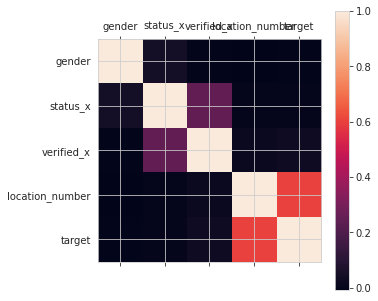

In [221]:
# Get the 0th restaurant data
real_path = "/content/drive/MyDrive/Bil573/train_data/restaurant_"

data = pd.read_csv("/content/drive/MyDrive/Bil573/train_data/restaurant_" + str(2) + ".csv")

cols_to_analyze = [87,88,89,90,107]
df = data.iloc[:, cols_to_analyze]
# pd.scatter_matrix(df, figsize=(6, 6))
plt.matshow(df.corr())
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
print(df.columns.values)
plt.colorbar()
plt.show()

(array([ 257.,    0.,    0.,    0.,    0., 1562.,    0.,    0.,    0.,
         114.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

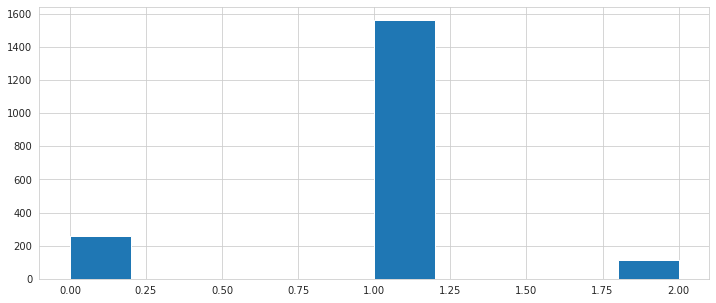

In [202]:
counts, bins = np.histogram(data['gender'])
plt.hist(bins[:-1], bins, weights=counts)


In [206]:
tmp = data.iloc[:, [87,90,91,92,93,105]]
tmp.columns.values

array(['gender', 'location_number', 'location_type', 'latitude_x',
       'longitude_x', 'location_number_obj'], dtype=object)

In [ ]:
data['location_number'].value_counts()

In [223]:
x = np.array([1,2,5,8,10,20,40])
y1 = np.array([0.997,0.964,0.880,0.787,0.718,0.494,0.269])
y2 = np.array([0.997,0.979,0.942,0.909,0.886,0.872,0.889])
y3 = np.array([0.773,0.805,0.847,0.881,0.894,0.948,0.985])

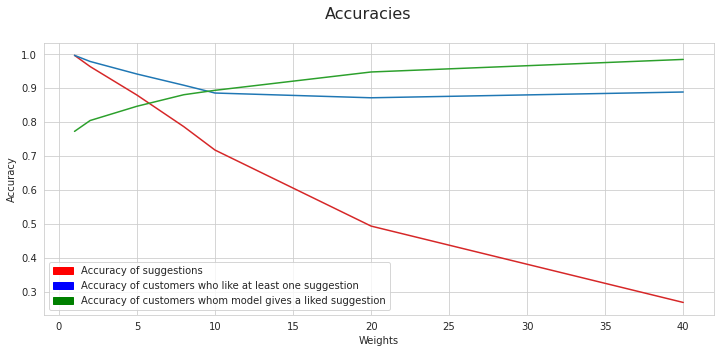

In [224]:
fig, ax1 = plt.subplots()
import matplotlib.patches as mpatches
fig.suptitle('Accuracies', fontsize=16)
ax1.set_xlabel('Weights')
ax1.set_ylabel('Accuracy')
ax1.plot(x, y1, color='tab:red')
ax1.plot(x,y2, color='tab:blue')
ax1.plot(x,y3,color='tab:green')
red_patch = mpatches.Patch(color='red', label='Accuracy of suggestions')
blue_patch = mpatches.Patch(color='blue', label='Accuracy of customers who like at least one suggestion')
green_patch = mpatches.Patch(color='green', label='Accuracy of customers whom model gives a liked suggestion')
plt.legend(handles=[red_patch,blue_patch, green_patch])

plt.show()
